## 10. Обработка естественного языка

### Регрессия Надарая-Ватсона

Регрессия Надарая–Уотсона (NW) — это классический непараметрический метод, используемый для оценки условного математического ожидания случайной величины. Метод сводится к взвешенному усреднению наблюдаемых значений зависимой переменной, где веса определяются ядерной функцией, зависящей от близости точек данных к точке запроса. Эта концепция нашла концептуальное отражение в машинном обучении, в частности, в механизме внимания.

Механизм внимания, являющийся ключевым компонентом многих современных нейросетевых архитектур, таких как Transformers, вычисляет выход как взвешенную сумму значений (values). При этом веса внимания, определяющие степень важности каждого элемента, вычисляются на основе совместимости запроса (query) с ключами (keys). Такой подход можно рассматривать как обобщение принципа регрессии Надарая–Уотсона, где веса внимания интерпретируются как динамически вычисляемые функции ядра. Эти ядра определяют вклад каждого входного элемента в выходной результат на основе его релевантности запросу.

In [1]:
import plotly.graph_objs as go
import numpy             as np

# Generating synthetic data
np.random.seed(42)

def f(x):
    return 2 * np.sin(x) + x

n = 100


x_train = np.sort(np.random.rand(n) * 5)
y_train = f(x_train) + np.random.randn(n)

x_val = np.arange(0, 5, 0.1)
y_val = f(x_val)

# Kernel functions
def gaussian_kernel(x, x_i, bandwidth):
    return np.exp(-0.5 * ((x - x_i) / bandwidth) ** 2) / (bandwidth * np.sqrt(2 * np.pi))

def epanechnikov_kernel(x, x_i, bandwidth):
    u = (x - x_i) / bandwidth
    return 0.75 * (1 - u**2) / bandwidth if np.abs(u) <= 1 else 0

# Nadaraya-Watson estimator with attention weights
def nadaraya_watson_with_attention(x_query, X, Y, bandwidth, kernel_type='epanechnikov'):
    if kernel_type == 'gaussian':
        kernel = gaussian_kernel
    elif kernel_type == 'epanechnikov':
        kernel = epanechnikov_kernel
    else:
        raise ValueError("Unsupported kernel type. Use 'gaussian' or 'epanechnikov'.")

    weights = np.array([kernel(x_query, x_i, bandwidth) for x_i in X])
    attention_weights = weights / np.sum(weights)
    return np.sum(attention_weights * Y), attention_weights

# Parameters
bandwidth = 0.5
kernel_type = 'epanechnikov'  # Change to 'gaussian' or 'epanechnikov'

# Applying NW regression to the data
X_query = np.linspace(0, 5, 100)
Y_pred = np.array([nadaraya_watson_with_attention(x, x_train, y_train, bandwidth, kernel_type)[0] for x in X_query])

# Compute attention weights for each query point
attention_matrix = np.array([nadaraya_watson_with_attention(x, x_train, y_train, bandwidth, kernel_type)[1] for x in X_query])

# Plotting the Nadaraya-Watson regression results using Plotly
data_regression = [
    go.Scatter(x=x_val, y=y_val, mode='markers', name='Data', marker=dict(color='blue')),
    go.Scatter(x=X_query, y=Y_pred, mode='lines', name='Nadaraya-Watson Prediction', line=dict(color='red'))
]

layout_regression = go.Layout(
    title=f'Nadaraya-Watson Regression using {kernel_type.capitalize()} Kernel',
    xaxis=dict(title='X'),
    yaxis=dict(title='Y')
)

fig_regression = go.Figure(data=data_regression, layout=layout_regression)

# Plotting the attention weights heatmap using Plotly
heatmap = go.Heatmap(z=attention_matrix, x=X_query, y=Y_pred, colorscale='Viridis', name='Attention Weights')

layout_heatmap = go.Layout(
    title='Attention Weights Heatmap',
    xaxis=dict(title='Query Points'),
    yaxis=dict(title='Data Points')
)

fig_heatmap = go.Figure(data=[heatmap], layout=layout_heatmap)

# Display the figures
fig_regression.show()
fig_heatmap.show()


In [2]:
import unicodedata
import random
import torch
import time
import math
import re

import torch.nn.functional as F
import torch.nn            as nn
import numpy               as np

from torch.utils.data import TensorDataset, DataLoader, RandomSampler
from __future__ import unicode_literals, print_function, division

from torch import optim
from tqdm  import tqdm
from io    import open

# Автоматический выбор устройства с приоритетом: MPS -> CUDA -> CPU
device = torch.device(
    "mps" if torch.backends.mps.is_available() and torch.backends.mps.is_built() else
    "cuda" if torch.cuda.is_available() else 
    "cpu"
)

print(f"Используемое устройство: {device}")

Используемое устройство: mps


Люди нуждаются в общении. Из этой базовой потребности человека ежедневно возникает огромное количество письменных текстов. Учитывая обилие текстов в социальных сетях, чатах, электронных письмах, обзорах товаров, новостных статьях, научных работах и книгах, становится жизненно важным дать компьютерам возможность понимать их, чтобы предлагать помощь или принимать решения на основе человеческого языка.

Обработка естественного языка (Natural Language Processing) изучает взаимодействие между компьютерами и людьми с помощью естественных языков. На практике для обработки и анализа текстовых данных (естественного языка человека) очень часто используются методы обработки естественного языка, например, языковые модели и модели машинного перевода.

### Машинный перевод посредством рекуррентных сетей

Одним из главных открытий, вызвавших широкий интерес к современным `RNN`, стало значительное продвижение в прикладной области статистического машинного перевода. В этом случае модель получает предложение на одном языке и должна предсказать соответствующее предложение на другом. Обратите внимание, что предложения могут быть разной длины, а соответствующие слова в двух предложениях могут располагаться не в том же порядке из-за различий в грамматической структуре двух языков.

Набор данных представляет собой набор из нескольких тысяч пар переводов с английского на французский.

Скачаем набор данных

In [3]:
!curl  -o data.zip 'https://download.pytorch.org/tutorial/data.zip'
!unzip -o data.zip
!rm data.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2814k  100 2814k    0     0   922k      0  0:00:03  0:00:03 --:--:--  922k
Archive:  data.zip
  inflating: data/eng-fra.txt        
  inflating: data/names/Arabic.txt   
  inflating: data/names/Chinese.txt  
  inflating: data/names/Czech.txt    
  inflating: data/names/Dutch.txt    
  inflating: data/names/English.txt  
  inflating: data/names/French.txt   
  inflating: data/names/German.txt   
  inflating: data/names/Greek.txt    
  inflating: data/names/Irish.txt    
  inflating: data/names/Italian.txt  
  inflating: data/names/Japanese.txt  
  inflating: data/names/Korean.txt   
  inflating: data/names/Polish.txt   
  inflating: data/names/Portuguese.txt  
  inflating: data/names/Russian.txt  
  inflating: data/names/Scottish.txt  
  inflating: data/names/Spanish.txt  
  inflating: data/names/Vietnamese.txt  


Посмотрим, как устроен набор данных. Набор состоит из пар предложений на английском и французских языках.

In [4]:
!head data/eng-fra.txt

Go.	Va !
Run!	Cours !
Run!	Courez !
Wow!	Ça alors !
Fire!	Au feu !
Help!	À l'aide !
Jump.	Saute.
Stop!	Ça suffit !
Stop!	Stop !
Stop!	Arrête-toi !


Мы будем представлять каждое слово в языке как вектор `one-hot`. По сравнению с десятками символов, которые могут существовать в языке, слов намного больше, поэтому вектор кодировки намного больше. Однако мы немного схитрим и обрезаем данные, чтобы использовать только несколько тысяч слов на язык.

In [5]:
SOS_token = 0
EOS_token = 1

class Language:
    def __init__(self, name):
        self.name = name
        self.word2index = {                  }
        self.word2count = {                  }
        
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words    = 2  # Count SOS and EOS
    def add_sentence(self, sentence):
        for word in sentence.split(' '):
            self.add_word(word)

    def add_word(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1


Набор данных у нас в `Unicode`, поэтому для упрощения мы преобразуем символы `Unicode` в `ASCII`, выполним преобразование в нижний регистр и удалим большинство знаков препинания.

In [6]:
def unicode2ascii(s):
    return ''.join(
     c for c in unicodedata.normalize('NFD', s)
     if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters
def normalize_string(s):
    s = unicode2ascii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z!?]+", r" ", s)
    return s.strip()

Чтобы прочитать файл данных, мы разобьем его на строки, а затем разобьем строки на пары. Все файлы имеют формат `English → Other Language`, поэтому, если мы хотим выпонить перевод с `Other Language → English` мы добавили флаг `reverse`, чтобы поменять пары местами.

In [ ]:
def read_languages(language_1, language_2, reverse=False):
    print("Reading lines...")
    # Read the file and split into lines
    lines = open('data/%s-%s.txt' % (language_1, language_2), encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalize_string(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs           = [list(reversed(p)) for p in pairs]
        input_language  = Language(language_2)
        output_language = Language(language_1)
    else:
        input_language  = Language(language_1)
        output_language = Language(language_2)

    return input_language, output_language, pairs


Поскольку примеров предложений очень много, а мы хотим быстро обучиться, мы обрезаем набор данных, оставляя только относительно короткие и простые предложения. Здесь максимальная длина составляет 10 слов (включая концевые знаки препинания), и мы отсеиваем предложения, которые переводятся в форму «Я есть» или «Он есть» и т. д. (с учетом замененных ранее апострофов).

In [8]:
MAX_LENGTH = 20

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)

def filter_pair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and len(p[1].split(' ')) < MAX_LENGTH and p[1].startswith(eng_prefixes)

def filter_pairs(pairs):
    return [pair for pair in pairs if filter_pair(pair)]

Полный процесс подготовки данных выглядит следующим образом:

- Чтение текстового файла, разбиение на строки, разбиение строк на пары
- Нормализация текста, фильтрация по длине и содержанию
- Составление списков слов из предложений в парах

In [9]:
def prepare_data(language_1, language_2, reverse=False):
    input_language, output_language, pairs = read_languages(language_1, language_2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filter_pairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_language .add_sentence(pair[0])
        output_language.add_sentence(pair[1])
    print("Counted words:")
    print(input_language .name, input_language .n_words)
    print(output_language.name, output_language.n_words)
    return input_language, output_language, pairs

input_lang, output_lang, pairs = prepare_data('eng', 'fra', True)
print(random.choice(pairs))


Reading lines...
Read 135842 sentence pairs
Trimmed to 13056 sentence pairs
Counting words...
Counted words:
fra 5161
eng 3378
['tu es trop jeune pour savoir ce qu est une regle a calcul', 'you re too young to know what a slide rule is']


#### `Seq2Seq` модель или `Encoder-Decoder`

Рекуррентная нейронная сеть - это сеть, которая работает с последовательностью и использует свой собственный выход в качестве входа для последующих шагов.

Сеть Sequence to Sequence, или сеть seq2seq, или сеть Encoder Decoder, - это модель, состоящая из двух `RNN`, называемых кодером и декодером. 
Кодер считывает входную последовательность и выдает  вектор в качестве результата, а декодер считывает этот вектор, чтобы получить выходную последовательность.

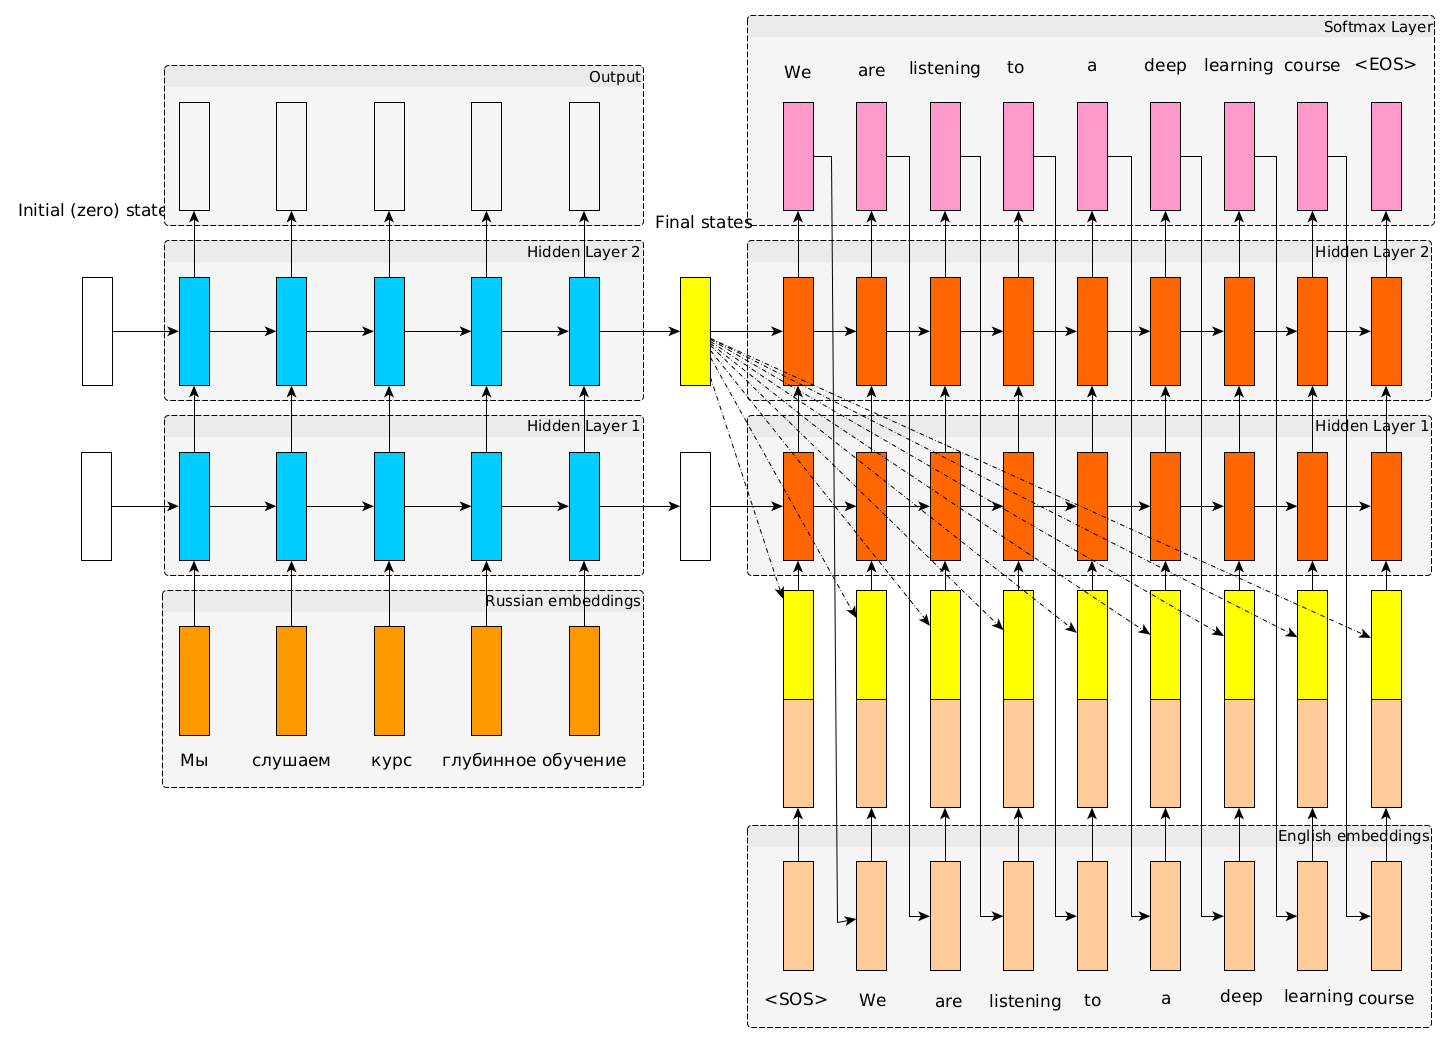

В отличие от предсказания последовательности с помощью одной `RNN`, где каждому входу соответствует выход, модель `seq2seq` позволяет обрабатывать последовательности разной длины и порядка, что делает ее идеальной для перевода между двумя языками.

Рассмотрим предложение `Je ne suis pas le chat noir → I am not the black cat`. Большинство слов во входном предложении имеют прямой перевод в выходном предложении, но расположены в несколько ином порядке, например `chat noir` и `black cat`. Из-за конструкции `ne/pas` в исходном предложении есть еще одно слово. Было бы сложно создать правильный перевод непосредственно на основе последовательности входных слов.

В модели `seq2seq` кодер создает единый вектор, который, в идеальном случае, кодирует «смысл» входной последовательности в единый вектор - единую точку в некотором N-мерном пространстве предложений.


Энкодер сети `seq2seq` - это `RNN`, которая выдает некоторое значение для каждого слова из входного предложения. Для каждого входного слова кодер выдает вектор и скрытое состояние и использует скрытое состояние для следующего входного слова.

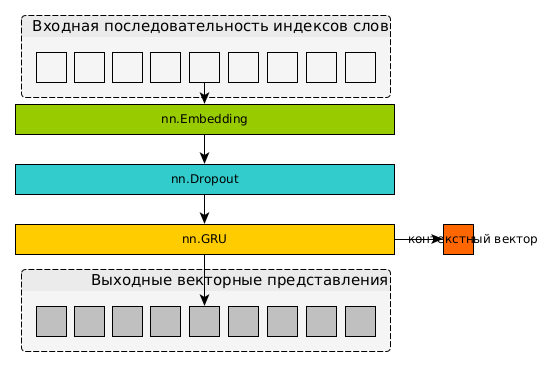

In [10]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_p=0.1):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru       = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.dropout   = nn.Dropout(dropout_p)

    def forward(self, input):
        embedded = self.dropout(self.embedding(input))
        output, hidden = self.gru(embedded)
        return output, hidden

Декодер - это еще одна сеть `RNN`, которая принимает выходной вектор(ы) кодера и выдает последовательность слов для создания перевода.

В простейшем декодере `seq2seq` мы используем только последний выход энкодера. Этот последний выход иногда называют контекстным вектором, поскольку он кодирует контекст всей последовательности. Этот вектор контекста используется в качестве начального скрытого состояния декодера.

На каждом шаге декодирования декодеру дается входной токен и скрытое состояние. Начальным входным токеном является токен начала строки `<SOS>`, а первым скрытым состоянием - вектор контекста (последнее скрытое состояние кодера).


<img title="Seq2Seq model" alt="Alt text" src="images/decoder_model.png" width="500" height="250">

In [11]:
class SimpleDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(SimpleDecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru       = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.out       = nn.Linear(hidden_size, output_size)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size      = encoder_outputs.size(0)
        decoder_input   = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        decoder_hidden  = encoder_hidden
        decoder_outputs = []

        for i in range(MAX_LENGTH):
            decoder_output, decoder_hidden  = self.forward_step(decoder_input, decoder_hidden)
            decoder_outputs.append(decoder_output)

            if target_tensor is not None:
                # Teacher forcing: Feed the target as the next input
                decoder_input = target_tensor[:, i].unsqueeze(1) # Teacher forcing
            else:
                # Without teacher forcing: use its own predictions as the next input
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()  # detach from history as input

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        return decoder_outputs, decoder_hidden, None # We return `None` for consistency in the training loop

    def forward_step(self, input, hidden):
        output         = self.embedding(input)
        output         = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.out(output)
        return output, hidden


Подготовка тренировочных данных

In [12]:
def indexes_from_sentence(language, sentence):
    return [language.word2index[word] for word in sentence.split(' ')]

def tensor_from_sentence(language, sentence):
    indexes = indexes_from_sentence(language, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(1, -1)

def tensors_from_pair(pair):
    input_tensor  = tensor_from_sentence(input_lang , pair[0])
    target_tensor = tensor_from_sentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

def get_dataloader(batch_size):
    input_language, output_language, pairs = prepare_data('eng', 'fra', True)

    n = len(pairs)
    input_ids  = np.zeros((n, MAX_LENGTH), dtype=np.int32)
    target_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)

    for idx, (inp, tgt) in enumerate(pairs):
        inp_ids = indexes_from_sentence(input_language , inp)
        tgt_ids = indexes_from_sentence(output_language, tgt)
        inp_ids.append(EOS_token)
        tgt_ids.append(EOS_token)
        input_ids [idx, :len(inp_ids)] = inp_ids
        target_ids[idx, :len(tgt_ids)] = tgt_ids

    train_data = TensorDataset(torch.LongTensor(input_ids).to(device), torch.LongTensor(target_ids).to(device))

    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
    return input_language, output_language, train_dataloader


Функции тренировки модели

Для обучения мы пропускаем входное предложение через кодировщик и отслеживаем каждый выход и последнее скрытое состояние. Затем декодеру дается токен <SOS> в качестве первого входа и последнее скрытое состояние кодера в качестве первого скрытого состояния.

`teacher forcing` - это концепция использования реальных целевых выходов в качестве каждого следующего входа, вместо того чтобы использовать предсказание декодера в качестве следующего входа. Использование `teacher forcing` приводит к более быстрой сходимости, но когда обученная сеть используется, она может проявлять нестабильность.

Благодаря свободе, которую дает нам автоград `PyTorch`, мы можем произвольно выбирать, использовать `teacher forcing` или нет, с помощью простого оператора `if`. Повысьте значение параметра `teacher_forcing_ratio`, чтобы использовать его чаще.

In [13]:
def train_epoch(dataloader, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion):

    total_loss = 0
    for data in dataloader:
        input_tensor, target_tensor = data

        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, _, _ = decoder(encoder_outputs, encoder_hidden, target_tensor)

        loss = criterion(
            decoder_outputs.view(-1, decoder_outputs.size(-1)),
            target_tensor.view(-1)
        )
        loss.backward()

        encoder_optimizer.step()
        decoder_optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)


In [14]:
def train(train_dataloader, encoder, decoder, n_epochs, learning_rate=0.001):
    output_loss_s = []
    print_loss_total, print_every = 0, 5  # Reset every print_every
    
    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    
    criterion = nn.NLLLoss()

    for epoch in range(1, n_epochs + 1):
        loss = train_epoch(train_dataloader, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)

        print_loss_total += loss
        
        if epoch % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            output_loss_s.append(print_loss_avg)
            print_loss_total = 0
            print(f"{epoch:5}, {epoch / n_epochs * 100:2f}, {print_loss_avg:5f}")
   
    return output_loss_s

Функции тестирования модели

In [15]:
def evaluate(encoder, decoder, sentence, input_lang, output_lang):
    with torch.no_grad():
        input_tensor = tensor_from_sentence(input_lang, sentence)

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, decoder_hidden, decoder_attn = decoder(encoder_outputs, encoder_hidden)

        _, topi = decoder_outputs.topk(1)
        decoded_ids = topi.squeeze()

        decoded_words = []
        for idx in decoded_ids:
            if idx.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            decoded_words.append(output_lang.index2word[idx.item()])
    return decoded_words, decoder_attn


In [16]:
def random_evaluate(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, _ = evaluate(encoder, decoder, pair[0], input_lang, output_lang)
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')


Решим задачу для нашего энкодера и простого декодера

In [17]:
hidden_size = 128
batch_size  = 32
num_epochs = 80

input_lang, output_lang, train_dataloader = get_dataloader(batch_size)

encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder = SimpleDecoderRNN(hidden_size, output_lang.n_words).to(device)

simple_model_loss_s = train(train_dataloader, encoder, decoder, num_epochs)

Reading lines...
Read 135842 sentence pairs
Trimmed to 13056 sentence pairs
Counting words...
Counted words:
fra 5161
eng 3378
    5, 6.250000, 1.017545
   10, 12.500000, 0.573942
   15, 18.750000, 0.402024
   20, 25.000000, 0.297781
   25, 31.250000, 0.228349
   30, 37.500000, 0.178645
   35, 43.750000, 0.143096
   40, 50.000000, 0.116662
   45, 56.250000, 0.095471
   50, 62.500000, 0.079947
   55, 68.750000, 0.067657
   60, 75.000000, 0.058065
   65, 81.250000, 0.050199
   70, 87.500000, 0.044146
   75, 93.750000, 0.039390
   80, 100.000000, 0.035906


In [18]:
encoder.eval()
decoder.eval()

SimpleDecoderRNN(
  (embedding): Embedding(3378, 128)
  (gru): GRU(128, 128, batch_first=True)
  (out): Linear(in_features=128, out_features=3378, bias=True)
)

In [19]:
random_evaluate(encoder, decoder)

> je suis chez tom
= i m at tom s house
< really ll to go to bed <EOS>

> je suis assez contente
= i m happy enough
< after young sure <EOS>

> je ne suis pas tres athletique
= i m not very athletic
< i m still not sure <EOS>

> il travaille sur un nouveau roman
= he is working on a new novel
< he is saving up to go out of age <EOS>

> je suis tres heureux que vous ayez souscrit a ce projet
= i am very happy that you have agreed to that plan
< i am so happy to tell you what i did <EOS>

> je suis nouveau ici
= i am new here
< i am sure this under on the street <EOS>

> je suis voyant
= i m psychic
< neither in the coming election <EOS>

> tu es jeune
= you re young
< you re lucky of you all i don t know it <EOS>

> tu es incroyablement talentueuse
= you re incredibly talented
< you re three glad to have to deal with <EOS>

> je ne suis pas vegetarien
= i m not a vegetarian
< neither being more got to speak to bed <EOS>



#### Реккурентные сети и механизм внимания

Механизм внимания `BahdanauAttention`

`Bahdanau Attention`, также известное как аддитивное внимание, является широко используемым механизмом внимания в моделях `seq2seq`, особенно в задачах нейронного машинного перевода. Этот механизм внимания использует выученную модель выравнивания для расчета `scores` внимания между скрытыми состояниями кодера и декодера. Для расчета `scores` выравнивания используется нейронная сеть.

Cуществуют и альтернативные механизмы внимания, такие как внимание Луонга, которое рассчитывает баллы внимания путем взятия точечного произведения между скрытым состоянием декодера и скрытым состоянием кодера. При этом не происходит нелинейного преобразования, используемого во внимании Бахданау.

Оценки выравнивания $e_{t,i}$ рассчитываются с помощью нейронной сети , которая принимает в качестве входных данных предыдущее скрытое состояние декодера $s_{t-1}$ и скрытое состояние энкодера $h_i$:

$e_{t,i} = v_a^T \tanh(W_a s_{t-1} + U_a h_i)$

Оценки выравнивания нормализуются с помощью функции `softmax` для получения весов внимания $\alpha_{t,i}$

$\alpha_{t,i} = \dfrac{\exp(e_{t,i})}{\sum_{j=1}^{T} \exp(e_{t,j})}$

Вектор контекста $c_t$ вычисляется как взвешенная сумма скрытых состояний энкодера $h_t$:

$c_t = \sum_{i=1}^{T} \alpha_{t,i} h_i$

Вектор контекста $c_t$ объединяется с предыдущим скрытым состоянием декодера $s_{t-1}$ и пропускается через другую сеть для получения выходной лексемы $y_t$:

$y_t = \text{Generate}(c_t, s_{t-1})$


In [20]:
class BahdanauAttention(nn.Module):
    def __init__(self, hidden_size):
        super(BahdanauAttention, self).__init__()
        self.Wa = nn.Linear(hidden_size, hidden_size)
        self.Ua = nn.Linear(hidden_size, hidden_size)
        self.Va = nn.Linear(hidden_size, 1)

    def forward(self, query, keys):
        scores = self.Va(torch.tanh(self.Wa(query) + self.Ua(keys)))
        scores = scores.squeeze(2).unsqueeze(1)

        weights = F.softmax(scores, dim=-1)
        context = torch.bmm(weights, keys)

        return context, weights

В качестве примера приведем реализацию `LuongAttention`

Для `LuongAttention` оценка выравнивания $e_{t,i}$ могут быть рассчитаны различными методами. Здесь мы используем «общий» метод, при котором баллы выравнивания вычисляются точечным произведением между скрытым состоянием кодера $h_i$ и скрытым состоянием декодера $s_t$:

$e_{t,i} = h_i^T W_a s_t$

Оценки выравнивания нормализуются с помощью функции `softmax` для получения весов внимания $\alpha_{t,i}$

$\alpha_{t,i} = \frac{\exp(e_{t,i})}{\sum_{j=1}^{T} \exp(e_{t,j})}$


Вектор контекста $c_t$ вычисляется как взвешенная сумма скрытых состояний кодера $h_t$:

$c_t = \sum_{i=1}^{T} \alpha_{t,i} h_i$

Вектор контекста $c_t$ объединяется со скрытым состоянием декодера $s_t$ и пропускается через другую сеть с прямолинейным движением для получения выходного токена $y_t$:

$\tilde{s}_t = \tanh(W_c [c_t; s_t])$

$y_t = \text{Generate}(\tilde{s}_t)$

In [21]:
class LuongAttention(nn.Module):
    def __init__(self, hidden_dim):
        super(LuongAttention, self).__init__()
        self.hidden_dim = hidden_dim
        self.attn = nn.Linear(hidden_dim, hidden_dim)

    def forward(self, hidden, encoder_outputs):
        # hidden: [batch_size, hidden_dim]
        # encoder_outputs: [batch_size, seq_len, hidden_dim]
        # Calculate alignment scores
        scores = torch.bmm(encoder_outputs, hidden.unsqueeze(2)).squeeze(2)  # [batch_size, seq_len]
        # Normalize the scores to obtain attention weights
        weights = F.softmax(scores, dim=1)  # [batch_size, seq_len]
        # Calculate context vector
        context = torch.bmm(weights.unsqueeze(1), encoder_outputs).squeeze(1)  # [batch_size, hidden_dim]
        
        return context, attn_weights

Декодер с механизмом внимания

<img title="Seq2Seq model" alt="Alt text" src="images/neural_machine_translation_with_attention_v2.png" width="1000" height="500">


In [22]:
class AttentionDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1):
        super(AttentionDecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.attention = BahdanauAttention(hidden_size)
        self.gru       = nn.GRU(2 * hidden_size, hidden_size, batch_first=True)
        self.out       = nn.Linear(hidden_size, output_size)
        self.dropout   = nn.Dropout(dropout_p)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size      = encoder_outputs.size(0)
        decoder_input   = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        decoder_hidden  = encoder_hidden
        decoder_outputs = []
        attentions      = []
        
        for i in range(MAX_LENGTH):
            decoder_output, decoder_hidden, attn_weights = self.forward_step(
                decoder_input, decoder_hidden, encoder_outputs
            )
            decoder_outputs.append(decoder_output)
            attentions     .append(attn_weights  )

            if target_tensor is not None:
                # Teacher forcing: Feed the target as the next input
                decoder_input = target_tensor[:, i].unsqueeze(1) # Teacher forcing
            else:
                # Without teacher forcing: use its own predictions as the next input
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()  # detach from history as input

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        attentions = torch.cat(attentions, dim=1)

        return decoder_outputs, decoder_hidden, attentions
    
    def forward_step(self, input, hidden, encoder_outputs):
        embedded =  self.dropout(self.embedding(input))

        query = hidden.permute(1, 0, 2)
        context, attn_weights = self.attention(query, encoder_outputs)
        input_gru = torch.cat((embedded, context), dim=2)

        output, hidden = self.gru(input_gru, hidden)
        output = self.out(output)

        return output, hidden, attn_weights

In [23]:
hidden_size = 128
batch_size  = 32

input_lang, output_lang, train_dataloader = get_dataloader(batch_size)

encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder = AttentionDecoderRNN(hidden_size, output_lang.n_words).to(device)

attention_model_loss_s = train(train_dataloader, encoder, decoder, num_epochs)

Reading lines...
Read 135842 sentence pairs
Trimmed to 13056 sentence pairs
Counting words...
Counted words:
fra 5161
eng 3378
    5, 6.250000, 0.927919
   10, 12.500000, 0.418808
   15, 18.750000, 0.227159
   20, 25.000000, 0.132124
   25, 31.250000, 0.084202
   30, 37.500000, 0.059243
   35, 43.750000, 0.044709
   40, 50.000000, 0.035965
   45, 56.250000, 0.030623
   50, 62.500000, 0.026655
   55, 68.750000, 0.024161
   60, 75.000000, 0.022136
   65, 81.250000, 0.020810
   70, 87.500000, 0.019450
   75, 93.750000, 0.018447
   80, 100.000000, 0.017777


In [24]:
import plotly.graph_objects as go

# Create a figure
fig = go.Figure()
# Add the first line plot
fig.add_trace(go.Scatter(
 x=list(range(num_epochs)),
 y=simple_model_loss_s, 
 mode='lines', 
 name='Simple Model'
))
# Add the second scatter plot
fig.add_trace(go.Scatter(
 x=list(range(num_epochs)),
 y=attention_model_loss_s, 
 mode='lines', 
 name='Model with attention',
 marker=dict(color='red')
))
# Show the plot
fig.show()


In [25]:
def show_attention(input_sentence, output_words, attentions):
    # Create the heatmap
    fig = go.Figure(data=go.Heatmap(
     z=attentions.cpu().numpy(),
     x=input_sentence.split(' ') + ['<EOS>'],
     y=output_words     
    ))
    # Update the layout to rotate x-axis labels and show ticks at every label
    fig.update_layout(
     xaxis=dict(
      tickmode='array',
      tickvals=list(range(len(input_sentence.split(' ')) + 1)),
      ticktext=input_sentence.split(' ') + ['<EOS>'],
      tickangle=90
     ),
     yaxis=dict(
      tickmode='array',
      tickvals=list(range(len(output_words))),
      ticktext=output_words
     ),
     title='Attention Weights',
     xaxis_title='Input Sentence',
     yaxis_title='Output Words',
     height=500, width=500
    )
    # Show the plot
    fig.show()


def evaluate_and_show_attention(input_sentence):
    output_words, attentions = evaluate(encoder, decoder, input_sentence, input_lang, output_lang)
    print('input =' , input_sentence)
    print('output =', ' '.join(output_words))
    show_attention(input_sentence, output_words, attentions[0, :len(output_words), :])


In [26]:
evaluate_and_show_attention('il n est pas aussi grand que son pere'      )
evaluate_and_show_attention('je suis trop fatigue pour conduire'         )
evaluate_and_show_attention('je suis desole si c est une question idiote')
evaluate_and_show_attention('je suis reellement fiere de vous'           )

input = il n est pas aussi grand que son pere
output = he is not as his father as his father <EOS>


input = je suis trop fatigue pour conduire
output = i am too tired to drive <EOS>


input = je suis desole si c est une question idiote
output = i m sorry if this is a stupid question <EOS>


input = je suis reellement fiere de vous
output = i m really proud of you <EOS>
